**Universidade Federal de Minas Gerais**  
**Departamento de Ciência da Computação**  
**Aprendizado de Máquina**  
**Valéria Pereira de Souza**    

## Trabalho Prático 1 - Classificação de Exoplanetas

# Apresentação do problema

Um KOI - Kepler Object of Interest é uma corpo celeste que se suspeita ser um exoplaneta. A partir da observação de diversas características, o corpo é classificado como KOI e posteriormente, após novas verificações é feita a classificação dos KOI em "Confirmado" ou "Falso positivo". 

O objetivo é comparar o desempenho de diversos classificadores na tarefa de classificação automática de um KOI como exoplaneta confirmado ou falso positivo.

## 1. Inspeção, limpeza e preparação dos dados

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings('ignore')

In [4]:
INPUT_FILEPATH = "koi_data.csv"
TARGET = "koi_disposition"
N_FOLDS = 5

###### Inspeção Inicial

In [11]:
data_raw = pd.read_csv(INPUT_FILEPATH)
data_raw.head(5)

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


Observarmos 43 colunas, das quais uma se refere ao código de cada KOI e outra se refere à anotação do dado de interesse (y).

###### Tipos de dados

In [6]:
data_raw.dtypes

kepoi_name           object
koi_disposition      object
koi_period          float64
koi_impact          float64
koi_duration        float64
koi_depth           float64
koi_ror             float64
koi_srho            float64
koi_prad            float64
koi_sma             float64
koi_incl            float64
koi_teq             float64
koi_insol           float64
koi_dor             float64
koi_max_sngle_ev    float64
koi_max_mult_ev     float64
koi_model_snr       float64
koi_steff           float64
koi_slogg           float64
koi_smet            float64
koi_srad            float64
koi_smass           float64
koi_kepmag          float64
koi_gmag            float64
koi_rmag            float64
koi_imag            float64
koi_zmag            float64
koi_jmag            float64
koi_hmag            float64
koi_kmag            float64
koi_fwm_stat_sig    float64
koi_fwm_sra         float64
koi_fwm_sdec        float64
koi_fwm_srao        float64
koi_fwm_sdeco       float64
koi_fwm_prao        

###### Prepração do X, y

O dataset é composto majoritariamente por dados numéricos contínuos, não havendo necessidade de transformações de features categóricas. A coluna kepoi_name traz indentificadores únicos para cada instância. Dessa forma, não é uma feature discriminativa entre as classes e será desconsiderada. 

Após reservada em variável à parte, a coluna com as respostas também será removida do DataFrame

In [12]:
y = data_raw[TARGET]
X = data_raw.drop(columns=['kepoi_name', 'koi_disposition'])

###### Valores faltantes
Não existem valores faltantes

In [7]:
X.isnull().values.any()

False

###### Normalização

In [8]:
X.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
count,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,...,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,37.032237,0.717106,5.607025,21340.318993,0.235205,3.415370,112.230798,0.158146,81.181413,1143.721069,...,-0.355681,-0.805629,-0.000263,0.000439,-0.049743,-0.087413,1.930251,-0.038402,-0.098738,1.920226
std,88.417985,2.628207,6.962634,66989.808550,2.586213,25.131368,3699.799318,0.241792,16.308839,775.788868,...,10.978677,14.741473,0.065707,0.077519,2.465670,2.746534,3.147553,2.465094,2.734732,3.142764
min,0.306940,0.000000,0.104600,0.800000,0.001290,0.000040,0.080000,0.007200,2.290000,92.000000,...,-275.600000,-397.620000,-4.000000,-0.800000,-21.500000,-75.900000,0.000000,-23.600000,-76.600000,0.000000
25%,2.213962,0.226000,2.500250,176.800000,0.013058,0.176092,1.460000,0.033000,81.930000,615.250000,...,-0.500000,-0.570000,-0.000240,-0.000240,-0.270000,-0.291500,0.128250,-0.265250,-0.320000,0.180000
50%,7.386755,0.610000,3.805500,495.950000,0.024185,0.748045,2.600000,0.073650,87.890000,948.000000,...,0.000000,-0.030000,0.000000,0.000000,0.000000,0.000000,0.460000,-0.007000,-0.018000,0.453000
75%,23.448117,0.923750,6.000750,2120.525000,0.171260,2.267063,21.645000,0.158200,89.520000,1482.000000,...,0.500000,0.450000,0.000260,0.000280,0.230000,0.230000,2.570000,0.226250,0.250000,2.420000
max,1071.232620,100.806000,138.540000,864260.000000,99.870650,918.752390,200346.000000,2.034500,90.000000,9791.000000,...,97.780000,98.780000,1.190000,5.000000,45.680000,27.500000,88.600000,46.570000,31.200000,89.600000


Observarmos grande variância na escala de valores das features. Esse fato pode representar um problema para algoritmos paramétricos uma vez que features com valores mais extremos influenciarão mais o resultado enviesando artificalmente os modelos. Para evitar esse tipo de problema, faremos um procedimento de feature scaling pela técnica de normalização no intervalo (0, 1)

In [18]:
# Normalização das features
X = pd.DataFrame(minmax_scale(X, feature_range=(0, 1)))
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,...,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,0.034293,0.007114,0.039747,0.024691,0.002342,0.003717,0.000560,0.074457,0.899457,0.108436,...,0.737169,0.799384,0.770662,0.138007,0.319295,0.733197,0.021786,0.335779,0.709659,0.021431
std,0.082562,0.026072,0.050295,0.077511,0.025896,0.027354,0.018467,0.119268,0.185940,0.079986,...,0.029403,0.029697,0.012660,0.013365,0.036702,0.026562,0.035525,0.035130,0.025369,0.035075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001781,0.002242,0.017305,0.000204,0.000118,0.000192,0.000007,0.012726,0.907992,0.053949,...,0.736783,0.799859,0.770667,0.137890,0.316017,0.731223,0.001448,0.332546,0.707607,0.002009
50%,0.006611,0.006051,0.026734,0.000573,0.000229,0.000814,0.000013,0.032778,0.975943,0.088257,...,0.738122,0.800947,0.770713,0.137931,0.320036,0.734043,0.005192,0.336226,0.710408,0.005056
75%,0.021609,0.009164,0.042591,0.002453,0.001702,0.002468,0.000108,0.074483,0.994527,0.143314,...,0.739461,0.801914,0.770763,0.137979,0.323459,0.736267,0.029007,0.339550,0.712894,0.027009
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### Encoding dos valores alvo

In [19]:
label_encoder = LabelEncoder()
label_encoder.fit(['CONFIRMED', 'FALSE POSITIVE'])
y = label_encoder.transform(y)

## 2. Experimentos

#### *Classe utilitária*

In [140]:
class Experiment():
    def __init__(self):

        self.X_train, self.X_test = [], []
        self.y_train, self.y_test = [], []
        self.train_index, self.test_index = [], []
        self.train_pred, self.test_pred = [], []
        
        self.accuracy_train, self.accuracy_test = [], []
        self.precision_train, self.precision_test = [], []
        self.recall_train, self.recall_test = [], []
        self.f1_train, self.f1_test = [], []
        

    def run_naive_bayes(self):
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            clf = GaussianNB()
            clf = clf.fit(self.X_train, self.y_train)
            self.get_predictions(clf)
            self.get_metrics_per_fold()
    
    def run_decision_tree(self, depth):
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            clf = DecisionTreeClassifier(max_depth=depth)
            clf = clf.fit(self.X_train, self.y_train)
            self.get_predictions(clf)
            self.get_metrics_per_fold()
                
    def run_svm(self, kernel):
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            clf = SVC(kernel=kernel, probability=True, verbose=True)
            clf = clf.fit(self.X_train, self.y_train)
            self.get_predictions(clf)
            self.get_metrics_per_fold()
            
    
    def get_folds(self):
        kfold = KFold(N_FOLDS, True, 1)
        return kfold.split(X)
    
    def slice_fold(self):
        global X
        global y
        self.X_train = X.iloc[self.train_index]
        self.y_train = y[self.train_index]
        
        self.X_test = X.iloc[self.test_index]
        self.y_test = y[self.test_index]
        
        
    def get_predictions(self, clf):
        self.train_pred = clf.predict(self.X_train)
        self.test_pred = clf.predict(self.X_test)
        
    def get_metrics_per_fold(self):
        self.accuracy_train.append(accuracy_score(self.y_train, self.train_pred))
        self.accuracy_test.append(accuracy_score(self.y_test, self.test_pred))
        
        self.precision_train.append(precision_score(self.y_train, self.train_pred))
        self.precision_test.append(precision_score(self.y_test, self.test_pred))
        
        self.recall_train.append(recall_score(self.y_train, self.train_pred))
        self.recall_test.append(recall_score(self.y_test, self.test_pred))
        
        self.f1_train.append(f1_score(self.y_train, self.train_pred))
        self.f1_test.append(f1_score(self.y_test, self.test_pred))
        
    def print_results(self):
        print("Train")
        print("  Accuracy: {:.3f}".format(np.mean(self.accuracy_train)))
        print("  Precision: {:.3f}".format(np.mean(self.precision_train)))
        print("  Recall: {:.3f}".format(np.mean(self.recall_train)))
        print("  f1: {:.3f}".format(np.mean(self.f1_train)))

        print()
        
        print("Test")
        print("  Accuracy: {:.3f}".format(np.mean(self.accuracy_test)))
        print("  Precision: {:.3f}".format(np.mean(self.precision_test)))
        print("  Recall: {:.3f}".format(np.mean(self.recall_test)))
        print("  f1: {:.3f}".format(np.mean(self.f1_test)))
    
    def plot_folds(self):
        #line graph - all metrics X hiperparâmetro variado
        print()


In [125]:
def save_results(objeto, metrics = {}):
    """ 
    Função auxiliar que salva resultados de muitos experimentos
    """    
    metrics['accuracy_train'].append(np.mean(objeto.accuracy_train))
    metrics['accuracy_test'].append(np.mean(objeto.accuracy_test))
                            
    metrics['precision_train'].append(np.mean(objeto.precision_train))
    metrics['precision_test'].append(np.mean(objeto.precision_test))
    
    metrics['recall_train'].append(np.mean(objeto.recall_train))
    metrics['recall_test'].append(np.mean(objeto.recall_test))
    
    metrics['f1_train'].append(np.mean(objeto.f1_train))
    metrics['f1_test'].append(np.mean(objeto.f1_test))
  
    return metrics

In [130]:
def plot_results(metrics, name='Decision Tree', parameter='Altura'):
    
    plt.subplot()
    plt.title(name + ' - ACCURACY')
    plt.xlabel(parameter)
    plt.ylabel('Accuracy')
    plt.plot(metrics['accuracy_train'], label = 'treino')
    plt.plot(metrics['accuracy_test'], label = 'teste')
    plt.legend(loc='best')
    plt.show()

    plt.subplot()
    plt.title(name + ' - F1 SCORE')
    plt.xlabel('Altura da árvore')
    plt.ylabel('f1 score')
    plt.plot(metrics['f1_train'], label = 'treino')
    plt.plot(metrics['f1_test'], label = 'teste')
    plt.legend(loc='best')
    plt.show()

### 2.1 Naive Bayes - Baseline

O algoritmo Naive Bayes, no qual é calculada a probabilidade condicional de cada feature dado o rótulo observado. Dado que não conhecemos a distribuição dos dados e, levando em consideração que fenômenos complexos tendem à distribuição normal, será utlizada a implementação Gaussian Naive Bayes

In [48]:
baseline = Experiment()
baseline.run_naive_bayes()
baseline.print_results()

Train
  Accuracy: 0.917
  Precision: 0.980
  Recall: 0.878
  f1: 0.926

Test
  Accuracy: 0.918
  Precision: 0.980
  Recall: 0.880
  f1: 0.927


### 2.2 Decision Trees

Decision Tree é um classificador não paramétrico baseado na escolha de features de divisão das instâncias que reduza a entropia de cada divisão. Ou seja, a cada nível da árvore, o conjunto vai sendo subdivido a partir da feature que seja mais discriminativa. Se a árvore puder crescer livremente, os nós folha conterão, em cada folha, apenas instâncias do mesmo label (entropia zero) e, portanto, um grande ovefitting.

###### 2.2.1 Altura: ilimitada
Como podemos observar, a altura ilimitada causou desempenho de 100% em todas as métricas, com resultado inferior no dado de teste, evidenciando o overfitting. Ainda sim, o f1 de teste superou o baseline.

In [51]:
no_prunning = Experiment()
no_prunning.run_decision_tree(None)
no_prunning.print_results()

Train
  Accuracy: 1.000
  Precision: 1.000
  Recall: 1.000
  f1: 1.000

Test
  Accuracy: 0.945
  Precision: 0.954
  Recall: 0.955
  f1: 0.954


###### 2.2.2 Altura: variando de 1 a 30
Para reduzir o problema do overfitting, e tentar melhorar o poder de generalização do nosso modelo, vamos testar diferente limites de altura para a árvore

In [129]:
metrics={
    'accuracy_train':[],
    'precision_train':[],
    'recall_train':[],
    'f1_train':[],
    'accuracy_test':[],
    'precision_test':[],
    'recall_test':[],
    'f1_test':[]
}

decision_tree = Experiment()

for i in tqdm(range(1, 20+1)):
    decision_tree.run_decision_tree(i)
    metrics = save_results(decision_tree, metrics)


100%|██████████| 20/20 [00:10<00:00,  1.37it/s]


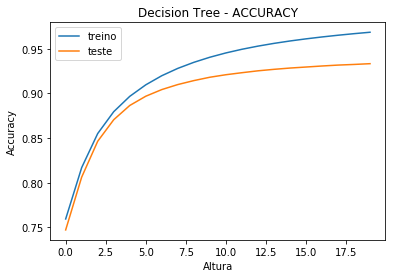

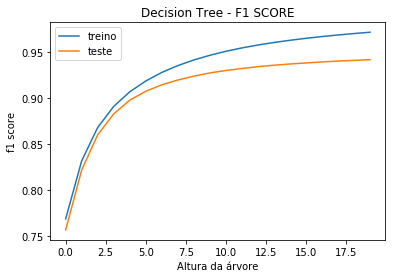

In [131]:
plot_results(metrics, name='Decision Tree', parameter='Altura')


### 3.2 SVM

In [141]:
metrics={
    'accuracy_train':[],
    'precision_train':[],
    'recall_train':[],
    'f1_train':[],
    'accuracy_test':[],
    'precision_test':[],
    'recall_test':[],
    'f1_test':[]
}

linear = Experiment()
kernels = ['linear', 'sigmoid', 'poly', 'rbf']
for kernel in kernels:
    print('Evaluating '+ kernel)
    linear.run_svm(kernel)
    metrics = save_results(decision_tree, metrics)


Evaluating linear
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Evaluating sigmoid
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Evaluating poly
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Evaluating rbf
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

### 3.3 kNN

### 3.4 Random Forest

### 3.5 Gradient Tree Boosting